# **Deep Learning Project - Anomaly Detection for Fiber Optic Cables**

Cost of Quality (COQ) is an estimated measure of the cost an organization faces due to the production of goods that are below the required quality (Duffy, 2013). The American Society for Quality estimates that costs of poor quality in an established organisation will be as much as 10-15% of operations. This figure can go as high as 40% for newer organisations making more specialised goods (Duffy, 2013).

In the manufacturing industry, a large portion of the CoQ is spent on manually inspecting goods at the end of the production process. While effective, this is a costly and time-consuming process. Additionally, for some types of good, like optical fibre cables, manual inspection can be tricky as even minor flaws in the bases of the cables that are hard to see with the naked eye, can majorly impact the product's performance.

In industries where goods are largely standardised, there is scope to automate this tedious process with great accuracy. This report will explore the use of deep learning models to automate the inspection process of finished goods. This will require an initial investment in camera systems installed at the end of the production line, but will save significant time and costs in the long run.

To emphasize the cost savings possible with anomaly detection, we can look at the case of Hemlock Semiconductor Operations (Lakey, 2021). Its polysilicon production process requires a purity level of 99.99% to meet expecations. With an automated anomaly detection system in place, HSC can detect and fix issues before they result in costly setbacks. Due to this system, the company reports a cost saving of $300,000 per month (Lakey, 2021).

This report will explore similar models to be used with standardised goods across the manufacturing industry.


# **Description of Data**

For this study, an anomaly detection dataset compiled by MVTec was used (Bergmann, Batzner, Fauser et al, 2021). This dataset was compiled for the purpose of testing different anomaly detection methods with a focus on the inspection of standardised, industrial goods. MVTec has distinct datasets for different industrial products, and the dataset containing optical fibre cable images was used for the purpose of this study. However, the findings discussed here apply to other standardised products as well.  

In the dataset, there were 224 images of 'normal' optical fibre cables, and 92 images of cables that had visible anomalies.


# **Data pre-processing**

The objective of this study was to develop an effective model for binary classification, that would simply inform whether or not a product had anomalies. The original data was organised such that defects of different categories were in separate folders. For example, cables that had defects in the outer insulation were in a separate folder than those that had defects in the inner insulation.

The image dataset was reorganised manually (without code) keeping the binary classification in mind, in the following manner.

- MVTec Dataset
  - Train
    - Normal
    - Defective
  - Validation
    - Normal
    - Defective
  - Test
    - Normal
    - Defective

In [ ]:
# Installing TensorFlow, which is an open-source machine learning framework developed by Google
pip install tensorflow

In [ ]:
import numpy as np  # Importing NumPy library for numerical operations and array manipulation
import tensorflow as tf  # Importing TensorFlow library for building and training machine learning models
from tensorflow.keras.models import Sequential  # Importing the Sequential model for linear stack of layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Importing layers for building neural networks
from tensorflow.keras.optimizers import Adam  # Importing the Adam optimizer for model optimization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importing ImageDataGenerator for image data augmentation

In [ ]:
# Importing the dataset to Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Define the base path to the dataset directory on Google Drive
base_path = '/content/drive/My Drive/cable dataset'

# Paths to train, validation, and test directories
train_dir = f'{base_path}/train'
validation_dir = f'{base_path}/validation'
test_dir = f'{base_path}/test'

# **Data Augmentation**
For a binary image classification task, this dataset, with only a few hundred product images, is extremely small. With a limited number of examples, the model may struggle to learn diverse features and patterns from the training data, leading to poor performance on unseen data. Data augmentation helps address this issue by generating additional training samples through various transformations such as rotation, shifting, flipping, and zooming.


The transformations carried out in the code below include rescaling the pixel values to a range between 0 and 1, randomly rotating images by up to 40 degrees, horizontally and vertically shifting images by up to 20% of their width and height, applying shear transformations, zooming into images, horizontally flipping images, and increasing the brightness of images within a specified range. Additionally, the fill_mode parameter specifies the strategy for filling in newly created pixels after transformations, while the channel_shift_range parameter controls the intensity of random channel shifts, and the vertical_flip parameter specifies the frequency of vertical flipping.


In [ ]:
# Carrying out data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, vertical_flip=2, fill_mode='nearest',
                                   channel_shift_range=20.0, brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation/test data

# Loading images from directory
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary', shuffle = True)
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary', shuffle = True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary', shuffle=True)

# **Defining a model evaluation metric**

To evaluate the models being developed, a custom F2 score will be developed.

In an image classification task like recognizing defective products in quality control where missing a positive instance carries a higher risk or cost than incorrectly identifying a negative instance as positive, the F2 score helps ensure the model's performance aligns with operational priorities by emphasizing the importance of capturing as many positive instances (defects) as possible.

While the F2 score prioritizes recall (sensitivity), it still incorporates precision into the evaluation, ensuring that the model does not achieve high recall at the extreme cost of precision (specificity).


In [ ]:
# Defining a custom F2 score metric. Using F2 as the model should prioritise sensitivity over specificity.
# The code in this cell has been generated by ChatGPT.

from tensorflow.keras import backend as K

def fbeta_score(beta=2):
    def fbeta(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        bb = beta ** 2
        fbeta_score = (1 + bb) * ((precision * recall) / (bb * precision + recall + K.epsilon()))
        return fbeta_score
    return fbeta

# **Building a simple neural network**
Initially, in an attempt to identify defects, a simple neural network was built, with two dense input layers only. The first dense layer has 128 units and the second had 64 units. The ReLU activation function is used for both.

For the final layer, a single-unit dense layer is used with the sigmoid activation function. This configuration is chosen because the task is to predict the probability that the image belongs to one of two classes (normal or defective).

Next, an optimizer had to be chosen for the compilation step. Upon research, the optimizer 'Adam' was deemed the most appropriate. The paper "Adam: A Method for Stochastic Optimization" discusses the widely-used algorithm (Kingma and Ba, 2015).

Adam uses first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. According to the paper, the method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data and/or parameters. Adam also combines the advantages of the Adaptive Gradient Algorithm and the Root Mean Square Propogation. It does this by preventing the learning rate for each parameter from diminishing too rapidly (as is the case in AdaGrad) and by using a bias-correction mechanism. Keeping these points in mind, this optimizer was used to compile the baseline neural network (Kingma and Ba, 2015).

While training the neural networks, I set the number of epochs to 10 (apart from the simplest neural netowrk, which performed the best with 9 epochs). For all the models in thie study, it was observed that at a value less than this, the models tend to underfit the training data, and at values over this, they tend to overfit. Thus, 10 epochs was found to be the best sweet spot between overfitting and underfitting.

The textbook "Deep Learning with Python" was referred to while building the first two models in this report.

In [ ]:
# Building a simple neural network with only dense layers
model1 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flattens the 150x150x3 images into a 1D vector
    Dense(128, activation='relu'),       # First dense layer with 128 neurons and ReLU activation
    Dense(64, activation='relu'),        # Second dense layer with 64 neurons and ReLU activation
    Dense(1, activation='sigmoid')       # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compiling the model
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), fbeta_score(beta=2)])

# Model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 67500)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               8640128   
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8648449 (32.99 MB)
Trainable params: 8648449 (32.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the simple neural network

model1train = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=9,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

model1train

Epoch 1/9
11/11 [==============================] - 21s 2s/step - loss: 1.3155 - accuracy: 0.6567 - recall_2: 0.9065 - fbeta: 0.7682 - val_loss: 1.3739 - val_accuracy: 0.6750 - val_recall_2: 1.0000 - val_fbeta: 0.9099
Epoch 2/9
11/11 [==============================] - 21s 2s/step - loss: 0.8103 - accuracy: 0.6368 - recall_2: 0.8276 - fbeta: 0.7176 - val_loss: 0.5622 - val_accuracy: 0.7000 - val_recall_2: 1.0000 - val_fbeta: 0.9201
Epoch 3/9
11/11 [==============================] - 20s 2s/step - loss: 0.7988 - accuracy: 0.6567 - recall_2: 0.8345 - fbeta: 0.8203 - val_loss: 0.7577 - val_accuracy: 0.6750 - val_recall_2: 1.0000 - val_fbeta: 0.9099
Epoch 4/9
11/11 [==============================] - 18s 2s/step - loss: 1.0663 - accuracy: 0.5622 - recall_2: 0.7394 - fbeta: 0.7386 - val_loss: 1.5395 - val_accuracy: 0.7000 - val_recall_2: 1.0000 - val_fbeta: 0.9201
Epoch 5/9
11/11 [==============================] - 20s 2s/step - loss: 0.9318 - accuracy: 0.6418 - recall_2: 0.8138 - fbeta: 0.7870 

In order to visualize the performance of this model, and to see how the training and validation metrics compare, we will make line graphs of the metrics over the 10 epochs.

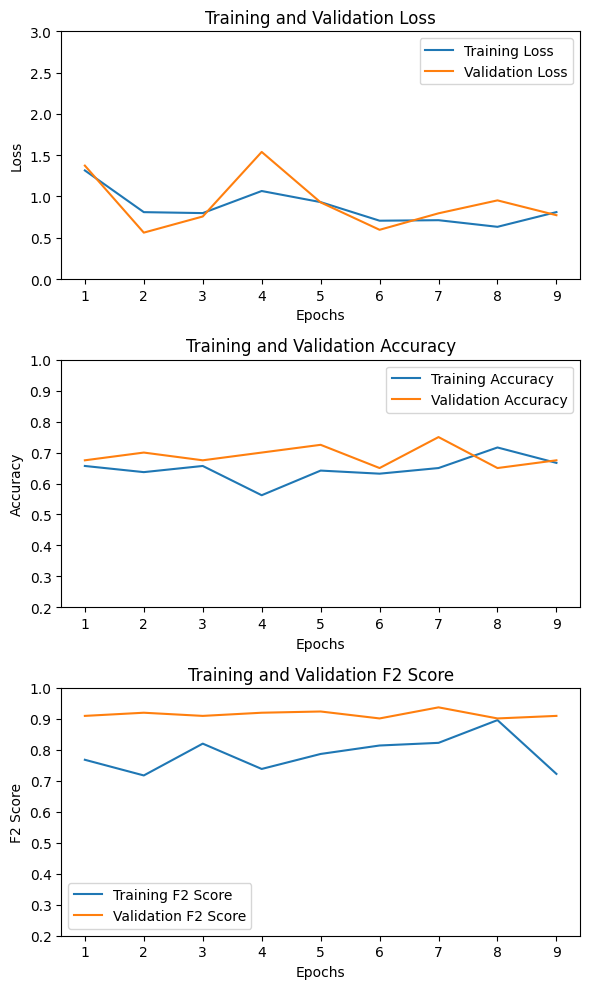

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy_fbeta(model1train):
    epochs = range(1, len(model1train.history['accuracy']) + 1)

    plt.figure(figsize=(6, 10))
    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, model1train.history['loss'], label='Training Loss')
    plt.plot(epochs, model1train.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0, 3)

    # Plot Training and Validation Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(epochs, model1train.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, model1train.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.2, 1)

    # Plot Training and Validation F2 Score
    plt.subplot(3, 1, 3)
    plt.plot(epochs, model1train.history['fbeta'], label='Training F2 Score')
    plt.plot(epochs, model1train.history['val_fbeta'], label='Validation F2 Score')
    plt.title('Training and Validation F2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F2 Score')
    plt.legend()
    plt.ylim(0.2, 1)

    plt.tight_layout()
    plt.show()

plot_loss_accuracy_fbeta(model1train)


The visualisations above suggest that the loss values for the training and validation datasets shows some improvement, but only by small margins. The accuracy hovers around 0.65 over the 9 epochs without any evidence of an upward or downward trend. The F2 score is relatively high, due to a strong recall.


In [ ]:
test_loss, test_acc, test_recall, test_f2 = model1.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test recall:', test_recall)
print('Test F2 score:', test_f2)

3/3 [==============================] - 3s 794ms/step - loss: 0.6982 - accuracy: 0.6939 - recall_2: 1.0000 - fbeta: 0.8671
Test loss: 0.6981592178344727
Test accuracy: 0.6938775777816772
Test recall: 1.0
Test F2 score: 0.867082417011261


The test dataset has a recall of 1. This means that the defects are correctly identified, but in some cases, normal cables are misidentified as defective. 69.39% of the total cables are correctly classified, and we will build more complex models to see if this figure can be improved.

# **Building a more complex neural network for better performance**

For a task as complex as image classification, where a lot of intricacies from the images have to be analysed, a simple model like the one above is insufficient. To improve the performance of the model, we will develop a convolutional neural network with more layers.

This CNN starts with a series of convolutional and max pooling layers, which are fundamental for feature detection and dimensionality reduction an image classification task. The use of multiple filters at each convolutional layer allows the model to learn a rich hierarchy of features, from simple curves to complex objects within the optical fiber images. Max pooling is utilized to reduce the spatial dimensions, thus lessening the amount of parameters and computation required in the network. The inclusion of a Dropout layer is a regularization technique to avoid overfitting which can easily memorize the training data due to their high capacity.

Here is the code used to develop this model along with a brief comment on each layer:

In [ ]:
# Building the complex model
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), # Convolutional layer with 32 filters of size 3x3, ReLU activation. First layer to extract features from images
    MaxPooling2D(2, 2),  # Max pooling layer with a 2x2 pool size to reduce spatial dimensions by half, helps reduce overfitting by summarizing the most prominent features.
    Conv2D(64, (3, 3), activation='relu'), # Second convolutional layer with 64 filters of size 3x3, ReLU activation. This captures more complex features in the images.
    MaxPooling2D(2, 2),  # Another max pooling layer to further reduce size and summarize features.
    Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with 128 filters, increasing the network's capacity to learn more complex features.
    MaxPooling2D(2, 2),  # Max pooling layer to reduce the feature map size.
    Conv2D(128, (3, 3), activation='relu'),  # Fourth convolutional layer, continuing to increase depth and feature extraction capability.
    MaxPooling2D(2, 2),  # Final max pooling layer, reducing size and summarizing features before classification.
    Flatten(),  # Flattening the 3D output to 1D to feed into the dense layer for classification.
    Dropout(0.5),  # Dropout layer with a rate of 0.5 to prevent overfitting by randomly setting input units to 0 during training.
    Dense(512, activation='relu'),  # Dense layer with 512 units, ReLU activation. Learns non-linear combinations of the high-level features extracted by the convolutional layers.
    Dense(1, activation='sigmoid')  # Output layer with a single neuron and sigmoid activation for binary classification. Outputs a probability indicating class membership.
])

In [ ]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall(), fbeta_score(beta=2)])

# Model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

In [ ]:
# Train the model
model2train = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10
11/11 [==============================] - 27s 2s/step - loss: 0.6150 - accuracy: 0.7065 - recall_3: 1.0000 - fbeta: 0.9264 - val_loss: 0.6644 - val_accuracy: 0.7000 - val_recall_3: 1.0000 - val_fbeta: 0.9211
Epoch 2/10
11/11 [==============================] - 27s 2s/step - loss: 0.5778 - accuracy: 0.7264 - recall_3: 1.0000 - fbeta: 0.8448 - val_loss: 0.6040 - val_accuracy: 0.6500 - val_recall_3: 1.0000 - val_fbeta: 0.9028
Epoch 3/10
11/11 [==============================] - 29s 3s/step - loss: 0.6120 - accuracy: 0.7091 - recall_3: 1.0000 - fbeta: 0.9228 - val_loss: 0.5633 - val_accuracy: 0.7000 - val_recall_3: 1.0000 - val_fbeta: 0.9174
Epoch 4/10
11/11 [==============================] - 26s 3s/step - loss: 0.5837 - accuracy: 0.7164 - recall_3: 1.0000 - fbeta: 0.9314 - val_loss: 0.6146 - val_accuracy: 0.6750 - val_recall_3: 1.0000 - val_fbeta: 0.9099
Epoch 5/10
11/11 [==============================] - 27s 2s/step - loss: 0.6139 - accuracy: 0.6915 - recall_3: 1.0000 - fbeta: 0.

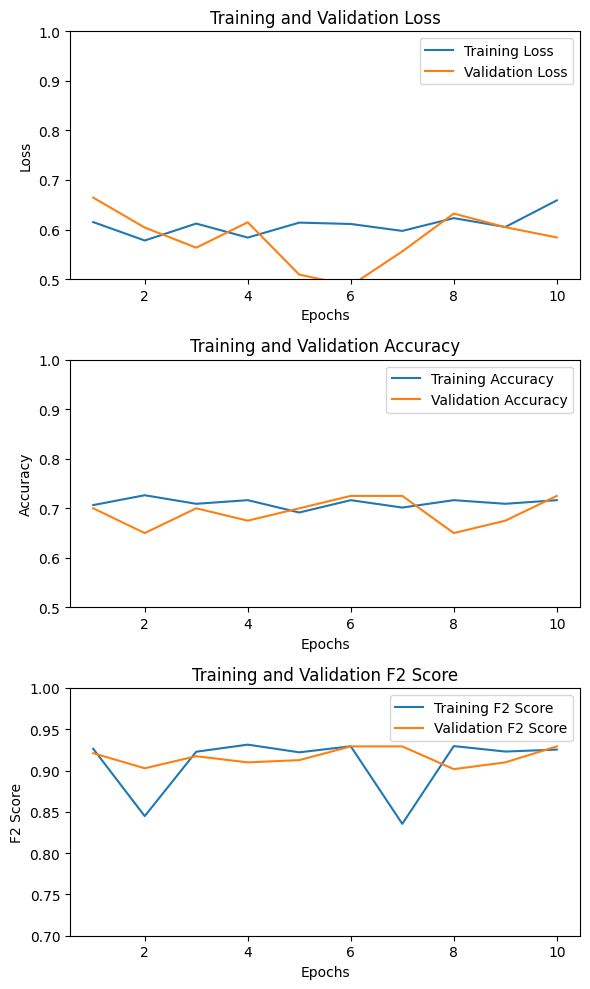

In [ ]:
def plot_loss_accuracy_fbeta_2(model2train):
    epochs = range(1, len(model2train.history['accuracy']) + 1)

    plt.figure(figsize=(6, 10))  # Adjusted figure size for better readability

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, model2train.history['loss'], label='Training Loss')
    plt.plot(epochs, model2train.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0.5, 1)

    # Plot Training and Validation Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(epochs, model2train.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, model2train.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.5, 1)

    # Plot Training and Validation F2 Score
    plt.subplot(3, 1, 3)
    plt.plot(epochs, model2train.history['fbeta'], label='Training F2 Score')
    plt.plot(epochs, model2train.history['val_fbeta'], label='Validation F2 Score')
    plt.title('Training and Validation F2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F2 Score')
    plt.legend()
    plt.ylim(0.7, 1)

    plt.tight_layout()
    plt.show()

plot_loss_accuracy_fbeta_2(model2train)

In this convolution neural network, there is a slight increase in accuracy over the simple neural network, as it hovers around 0.7 for all epochs. There is evidence of the loss value decreasing as well. The F2 is better than the previous model at around 0.92, but not significantly.

In [ ]:
# Evaluate the model
test_loss2, test_acc2, test_recall2, test_f2_2 = model2.evaluate(test_generator)
print('Test loss:', test_loss2)
print('Test accuracy:', test_acc2)
print('Test recall:', test_recall2)
print('Test F2 score:', test_f2_2)


3/3 [==============================] - 3s 888ms/step - loss: 0.6212 - accuracy: 0.6939 - recall_3: 1.0000 - fbeta: 0.9271
Test loss: 0.6212131977081299
Test accuracy: 0.6938775777816772
Test recall: 1.0
Test F2 score: 0.9270551204681396


While the test accuracy remains the same as in the simpler neural network, the test F2 score shows an improvement, by around 0.02. This means that fewer normal cables are being incorrectly classified as defective. The recall, which is the most crucial metric, is 1, which means all defects are flagged.

Overall, the added complexity has not had a drastic effect on the model's performance.

# **Using pre-trained models for anomaly detection**

After building the convolutional neural network, I wanted to test the effectiveness of pre-trained neural networks for this image classification task. The paper "A comparison between VGG16, VGG19 and ResNet50 architecture frameworks for Image Classification" compares the performance of three pre-trained models for the same image classification task (Mascarenhas and Agarwal, 2022).


The problem involves optimizing price comparison for a regional retail network by classifying and segregating products into correct categories using a dataset comprising 6000 images, along with textual data in the form of titles and descriptions. To do this, 3 pretrained convolutional neural networks were used: VGG16, VGG19 and ResNet 50. All 3 of them showed promising results in a multi-class image classification problem with a high accuracy of test data. ResNet 50 had the highest accuracy at 97.22%. It was also discovered that the models tend to overfit the training data above Epoch values of 20, and tend to underfit under Epoch values of 15 (Mascarenhas and Agarwal, 2022).

Based on this academic paper, I decided to try VGG16 and ResNet 50 for anomaly detection.

# **Building a VGG16 model**
VGG16 is a convolutional neural network (CNN) architecture renowned for its simplicity and depth. By stacking many convolutional layers together, VGG16 can capture complex patterns in the image data, such as textures, shapes, and objects, making it  effective for image classification. It employs max pooling to reduce the spatial dimensions of the output features, ReLU activation functions for non-linearity, and a final softmax layer to output a probability distribution over different classes.

The code below uses transfer learning; it adds custom layers to the pre-trained base to make it more suitable for the anomaly detection task.

In [ ]:
# Building a VGG16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Loading VGG16 pre-trained model
base_model = VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Freezing the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top (ChatGPT was referred to for this)
x = Flatten()(base_model.output) # Flattens the output of the base model to a single dimension
x = Dense(512, activation='relu')(x) # Add a Dense layer with 512 units and ReLU activation for non-linear transformation
x = Dropout(0.5)(x) # Reduces overfitting by randomly setting input units to 0 during training
x = Dense(1, activation='sigmoid')(x) # final Dense layer with sigmoid activation for binary classification


In [ ]:
# Compile the model
model3 = Model(base_model.input, x)
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), fbeta_score(beta=2)])

In [ ]:
# Training the model
VGG16train = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
11/11 [==============================] - 87s 8s/step - loss: 0.7042 - accuracy: 0.7065 - recall_4: 0.9301 - fbeta: 0.8906 - val_loss: 0.6384 - val_accuracy: 0.6500 - val_recall_4: 1.0000 - val_fbeta: 0.8984
Epoch 2/10
11/11 [==============================] - 84s 8s/step - loss: 0.6652 - accuracy: 0.6418 - recall_4: 0.8414 - fbeta: 0.8284 - val_loss: 0.6289 - val_accuracy: 0.7000 - val_recall_4: 1.0000 - val_fbeta: 0.9201
Epoch 3/10
11/11 [==============================] - 80s 7s/step - loss: 0.6364 - accuracy: 0.6716 - recall_4: 0.8483 - fbeta: 0.7474 - val_loss: 0.6532 - val_accuracy: 0.6500 - val_recall_4: 1.0000 - val_fbeta: 0.8992
Epoch 4/10
11/11 [==============================] - 92s 8s/step - loss: 0.6129 - accuracy: 0.6716 - recall_4: 0.8288 - fbeta: 0.7348 - val_loss: 0.5391 - val_accuracy: 0.7500 - val_recall_4: 1.0000 - val_fbeta: 0.9297
Epoch 5/10
11/11 [==============================] - 85s 8s/step - loss: 0.6273 - accuracy: 0.6766 - recall_4: 0.9097 - fbeta: 0.

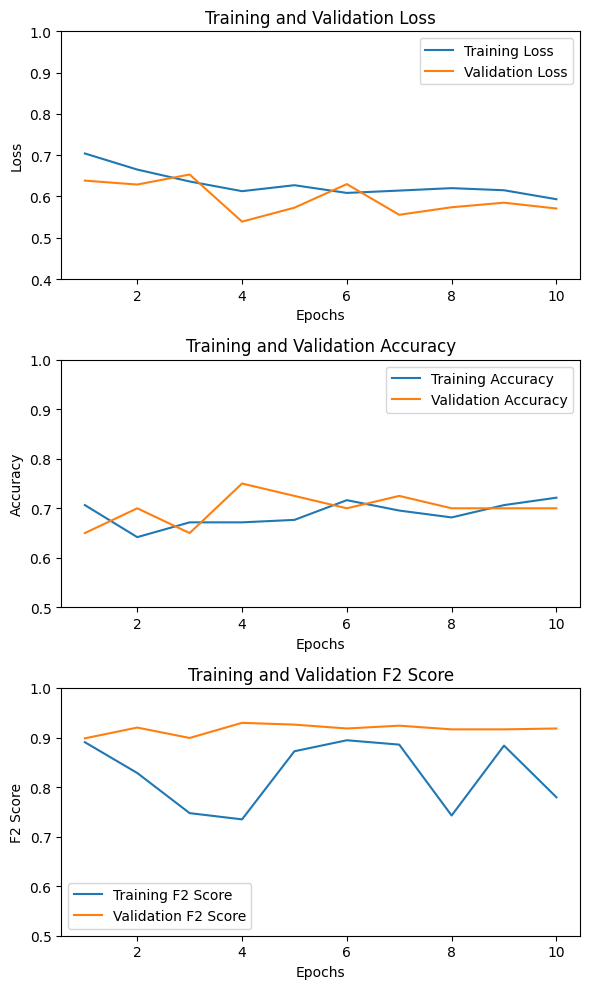

In [ ]:
def plot_loss_accuracy_fbeta_3(VGG16train):
    epochs = range(1, len(VGG16train.history['accuracy']) + 1)

    plt.figure(figsize=(6, 10))

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, VGG16train.history['loss'], label='Training Loss')
    plt.plot(epochs, VGG16train.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0.4, 1)

    # Plot Training and Validation Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(epochs, VGG16train.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, VGG16train.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.5, 1.0)

    # Plot Training and Validation F2 Score
    plt.subplot(3, 1, 3)
    plt.plot(epochs, VGG16train.history['fbeta'], label='Training F2 Score')
    plt.plot(epochs, VGG16train.history['val_fbeta'], label='Validation F2 Score')
    plt.title('Training and Validation F2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F2 Score')
    plt.legend()
    plt.ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()

plot_loss_accuracy_fbeta_3(VGG16train)

Using a pre-trained model as a base for another convolutional neural network in this case, has led to a lower loss than the two previous models. This suggests that this model is more adept at minimizing the discrepancy between predicted and actual values. The loss also has a clear trend downwards over the 10 epochs.

The training and validation accuracy also seem to converge through the last 4 epochs, and overall have less fluctuations than the two previous model. The overall accuracy still hovers around 0.7.

In [ ]:
# Evaluate the model

test_loss3, test_acc3, test_recall3, test_f2_3 = model3.evaluate(test_generator)
print('Test loss:', test_loss3)
print('Test accuracy:', test_acc3)
print('Test recall:', test_recall3)
print('Test F2 score:', test_f2_3)

3/3 [==============================] - 15s 3s/step - loss: 0.5058 - accuracy: 0.8163 - recall_4: 1.0000 - fbeta: 0.9530
Test loss: 0.5058131814002991
Test accuracy: 0.8163265585899353
Test recall: 1.0
Test F2 score: 0.9530186057090759


The model performs exceptionally well on training data, with a high accuracy and F2 score. Crucially, the test recall is also 1, which means all defects are appropriately flagged. Overall, the model has generalized well to unseen data, which is a hallmark of a robust deep learning model.

This scenario however, is rare, and could possibly be a sign of data leakage or the test set not being adequately representative of the problem space. Upon manually going through the dataset, there were no glaring issues found, and the test dataset of the 'defective' class had anomalies of multiple types (cuts in inner/outer insulation, frayed wiring etc.).

# **Building a ResNet 50 model**
ResNet 50 is a model widely used in various computer vision applications, including object detection, image classification, and more, due to its ability to learn rich and complex feature representations. Like VGG16, this architecture has shown remarkable performance in large-scale image recognition tasks, being pre-trained on millions of images from the ImageNet database.

Again, custom layers have been added to the pre-trained base to make it more suitable for the anomaly detection task.

In [ ]:
# Building a ResNet 50 model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

base_resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the layers of the base model
for layer in base_resnet_model.layers:
    layer.trainable = False

# Adding custom layers on top for the anomaly detection problem (ChatGPT was referred to for this)
y = base_resnet_model.output
y = GlobalAveragePooling2D()(y) # Global average pooling reduces each feature map to a single value, reducing complexity
y = Dense(1024, activation='relu')(y)  # New FC layer, random init
predictions = Dense(1, activation='sigmoid')(y)  # New softmax layer for binary classification

resnet_model = Model(inputs=base_resnet_model.input, outputs=predictions)

# Compipling the resnet model
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall(), fbeta_score(beta=2)])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Training the model

resnet50train = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
11/11 [==============================] - 47s 4s/step - loss: 0.7450 - accuracy: 0.5771 - recall_5: 0.6286 - fbeta: 0.5069 - val_loss: 0.8537 - val_accuracy: 0.6750 - val_recall_5: 1.0000 - val_fbeta: 0.9099
Epoch 2/10
11/11 [==============================] - 34s 3s/step - loss: 0.6690 - accuracy: 0.6219 - recall_5: 0.7660 - fbeta: 0.6485 - val_loss: 0.6390 - val_accuracy: 0.6750 - val_recall_5: 1.0000 - val_fbeta: 0.9119
Epoch 3/10
11/11 [==============================] - 39s 4s/step - loss: 0.6268 - accuracy: 0.7164 - recall_5: 1.0000 - fbeta: 0.8406 - val_loss: 0.6574 - val_accuracy: 0.6500 - val_recall_5: 1.0000 - val_fbeta: 0.9017
Epoch 4/10
11/11 [==============================] - 39s 4s/step - loss: 0.6482 - accuracy: 0.7015 - recall_5: 1.0000 - fbeta: 0.8348 - val_loss: 0.7018 - val_accuracy: 0.6250 - val_recall_5: 1.0000 - val_fbeta: 0.8780
Epoch 5/10
11/11 [==============================] - 34s 3s/step - loss: 0.6088 - accuracy: 0.7114 - recall_5: 1.0000 - fbeta: 0.

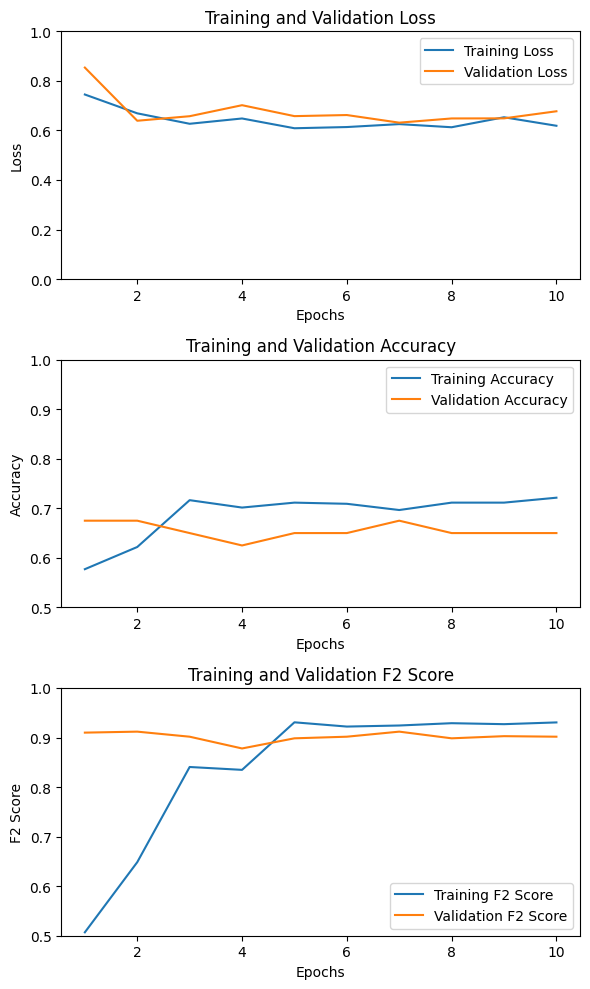

In [ ]:
def plot_loss_accuracy_fbeta_4(resnet50train):
    epochs = range(1, len(resnet50train.history['accuracy']) + 1)

    plt.figure(figsize=(6, 10))

    # Plot Training and Validation Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, resnet50train.history['loss'], label='Training Loss')
    plt.plot(epochs, resnet50train.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0, 1)

    # Plot Training and Validation Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(epochs, resnet50train.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, resnet50train.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.5, 1.0)

    # Plot Training and Validation F2 Score
    plt.subplot(3, 1, 3)
    plt.plot(epochs, resnet50train.history['fbeta'], label='Training F2 Score')
    plt.plot(epochs, resnet50train.history['val_fbeta'], label='Validation F2 Score')
    plt.title('Training and Validation F2 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F2 Score')
    plt.legend()
    plt.ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()

plot_loss_accuracy_fbeta_4(resnet50train)

Unlike the model based on VGG16, the ResNet 50 model has clear signs of overfitting, as the validation accuracy is consistently lower than training accuracy, and by a significant amount. The loss and F2 metrics show signs of improvement over the 10 epochs.

In [ ]:
# Evaluate the model
test_loss, test_acc, test_recall, test_f2 = resnet_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test recall:', test_recall)
print('Test F2 score:', test_f2)

3/3 [==============================] - 8s 2s/step - loss: 0.6296 - accuracy: 0.6939 - recall_5: 1.0000 - fbeta: 0.9263
Test loss: 0.6296476125717163
Test accuracy: 0.6938775777816772
Test recall: 1.0
Test F2 score: 0.9263384342193604


Overall, the model has a similar accuracy to the first 2 models, and a relatively high F2 score. Crucially, the test recall is 1. However, the model based on VGG16 outperforms ResNet 50 with respect to loss, accuracy and F2 score.

# **Conclusion and Evaluation of Methodology**

For the purpose of identifying anomalies in a dataset of finished product images, developing a convolutional neural network based on VGG16 yielded the best results. Following were the results from the test data:

**Test loss:** 0.506

**Test accuracy:** 0.816

**Test recall:** 1.000

**Test F2 score:** 0.953

Based on this, it is strongly recommended that VGG16-based models be prioritized in the development and implementation of automated anomaly detection systems, particularly in contexts involving image analysis of finished products.

However, it is important to recognize the limitations of this methodology.

Firstly, for even better performance of deep learning models in terms of accuracy, a bigger dataset should be used. While augmentation techniques such as rotation, scaling, and flipping can help, they inherently create variations of existing data rather than genuinely new samples.

Secondly, the dataset had a class imbalance, with a significant disparity in the distribution of the two categories. Images showcasing defects were considerably outnumbered by those representing normal conditions. This could be a challenge for the deep learning models, as the underrepresentation of defective images may lead to a predictive bias towards 'normal' products.

These factors mut be considered before deploying a model for anomaly detection.

# **Deployment of the Model**

The real-world deployment will be a structured process that should involve both the development and review of the system's platform and controls. A brief outline of the steps is highlighted below:

**Step 1: Hardware evaluation and procurement**

Aforementioned, the initial investment in a high-quality industrial camera will be significant, but in the long term, this will help reduce time and costs of quality checks. Following are some of the camera specifications that this inspection tasks will require:

1. **Resolution:** High-resolution cameras are essential. The model's accuracy depends significantly on the image quality. Cameras with a resolution of 12 megapixels or higher are recommended to capture fine details in the optical fiber cables.
2. **Frame Rate:** A higher frame rate is beneficial for real-time defect detection, especially in a fast-moving production line. Look for cameras that can offer 60 frames per second or more.
3. **Sensitivity:** Good low-light performance (high ISO capability) will ensure the camera can capture clear images under varying lighting conditions common in industrial environments.
4. **Durability:** Cameras must be robust and designed for industrial environments, capable of operating reliably in conditions that may include exposure to dust, moisture, and vibrations.

**Step 2: Software and Deep Learning Model Deployment**
The model should be deployed on a server or cloud environment that is capable of processing the incoming image data in real-time. This server should have high-performance GPUs to handle the computational load of the deep learning model.

**Step 3: Real-Time Analysis and Feedback**
1. **Real-Time Analysis:** The system should analyze images in real-time, providing instant feedback to operators or automated systems to remove or mark defective cables.
2. **Feedback Loop:** Implement a feedback loop where the system's performance can be continuously monitored and improved over time, based on its accuracy and the types of defects it detects.




# **Future Scope**

A promising direction for future research involves enhancing the methodology by using a multi-class classification framework. This method should ideally group defects into types. In this manner, deeper insights would be gained into the nature and cause of the defects, and could help manufacturers identify exactly what area of the production process to work on if defects need to be reduced.

Lastly, manufacturers should work on gathering a more comprehensive dataset for furhter analysis into the subject. The dataset used for this study had a class imbalance, and the number of images with anomalies was far lower than the number of normal product images. A more balanced dataset will take longer to gather due if the rate of defects is low, but could lead to better-performing models with respect to accuracy, precision and overall correct detection of defects.




# **Works Cited**

1. Chollet, François. Deep Learning with Python. Manning Publications, 2021.
2. Duffy, Grace L. The ASQ Quality Improvement Pocket Guide: Basic History, Concepts, Tools, and Relationships. ASQ Quality Press, 2013.  
3. Kingma, Diederik and Ba, Jimmy. Adam: A Method for Stochastic Optimization. ICLR, 2015.
4. Lakey, Elise. “How You Can Lower Costs and Optimize Operations like Hemlock Semiconductor.” Spotfire Blog, 08 Jul. 2021, www.spotfire.com/blog/2021/07/08/how-you-can-lower-costs-and-optimize-operations-like-hemlock-semiconductor/.
5. Mascarenhas, Sheldon, and Mukul Agarwal. “A Comparison between VGG16, VGG19 and Resnet50 Architecture Frameworks for Image Classification.” IEEE Xplore, 3 Feb. 2022, ieeexplore.ieee.org/document/9687944/.
6. Paul Bergmann, Kilian Batzner, Michael Fauser, David Sattlegger, Carsten Steger: The MVTec Anomaly Detection Dataset: A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection; in: International Journal of Computer Vision 129(4):1038-1059, 2021, DOI: 10.1007/s11263-020-01400-4.